Predicting Car Prices from Craigslist Data

Numéro du groupe : 4

Membres du groupe : Clément VURPILLOT, Andréa ZANIN, Antoine URSEL 

In [1]:
# ---------------------------------------------------------
# CELL 1: Imports & Environment Configuration
# ---------------------------------------------------------
import warnings
warnings.filterwarnings('ignore') # Clean output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Helper function to print scores nicely
def print_scores(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> MAE: {mae:.0f}$ | RMSE: {rmse:.0f}$ | R²: {r2:.4f}")
    return r2

print("-> Libraries loaded successfully.")

-> Libraries loaded successfully.


In [2]:
# ---------------------------------------------------------
# CELL 2: Data Loading & Cleaning
# ---------------------------------------------------------
print("--- 1. Loading Data ---")
# Download latest version
path = kagglehub.dataset_download("austinreese/craigslist-carstrucks-data")
csv_path = os.path.join(path, "vehicles.csv")

# Load Data
df = pd.read_csv(csv_path, low_memory=False)
print(f"Initial Shape: {df.shape}")

print("\n--- 2. Cleaning Data ---")
# 2.1 Filter Target Outliers (Price)
# We remove unrealistic prices (scams < $500 or outliers > $500k)
df = df[(df['price'] > 500) & (df['price'] < 500000)]

# 2.2 Drop Irrelevant Columns
cols_to_drop = ['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# 2.3 Handle Missing Values (Critical Columns)
essential_cols = ['year', 'manufacturer', 'model', 'odometer', 'fuel', 'transmission']
df = df.dropna(subset=essential_cols)

# 2.4 Drop rows with too much missing data (>40%)
df = df[df.isnull().mean(axis=1) < 0.4]

# 2.5 Feature Selection & Filling NaNs
# Keep only relevant features for modeling
final_cols = ['price', 'year', 'manufacturer', 'odometer', 'fuel', 'transmission', 'type', 'condition', 'drive', 'cylinders']
df = df[final_cols].copy()

# Fill categorical NaNs with 'unknown'
cat_cols = ['fuel', 'transmission', 'type', 'condition', 'drive', 'cylinders']
for col in cat_cols:
    df[col] = df[col].fillna('unknown')

print(f"-> Cleaning complete. Final Shape: {df.shape}")
display(df.head())

--- 1. Loading Data ---
Initial Shape: (426880, 26)

--- 2. Cleaning Data ---
-> Cleaning complete. Final Shape: (358493, 10)


,price,year,manufacturer,odometer,fuel,transmission,type,condition,drive,cylinders
27,33590,2014.0,gmc,57923.0,gas,other,pickup,good,unknown,8 cylinders
28,22590,2010.0,chevrolet,71229.0,gas,other,pickup,good,unknown,8 cylinders
29,39590,2020.0,chevrolet,19160.0,gas,other,pickup,good,unknown,8 cylinders
30,30990,2017.0,toyota,41124.0,gas,other,pickup,good,unknown,8 cylinders
31,15000,2013.0,ford,128000.0,gas,automatic,truck,excellent,rwd,6 cylinders


--- Generating Visualizations ---


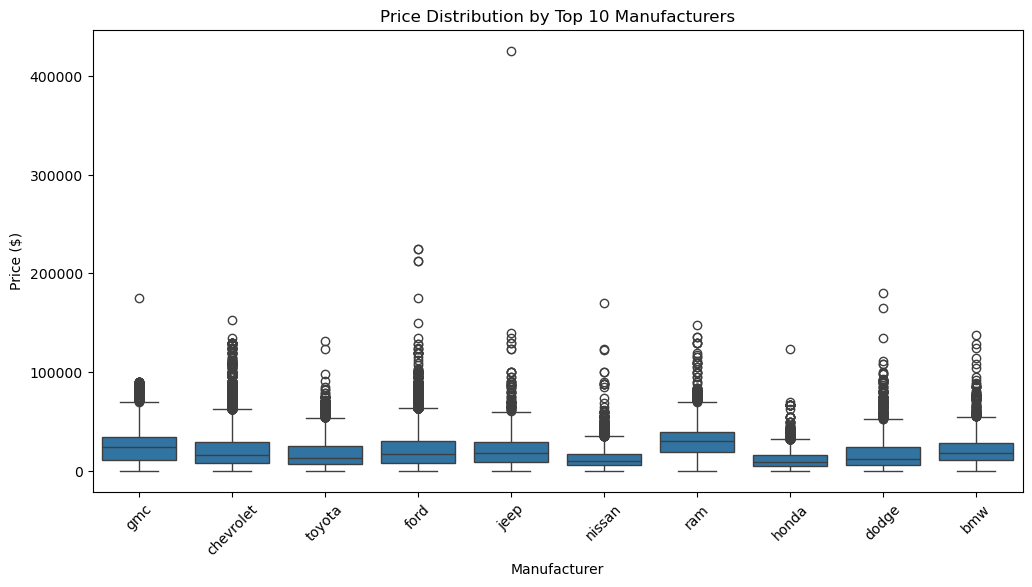

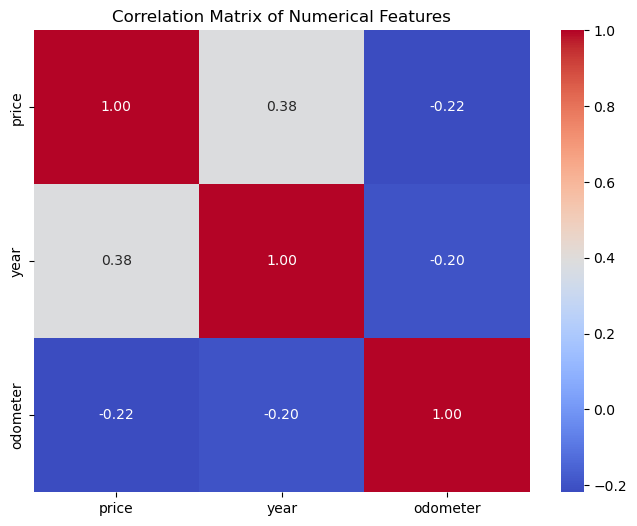

In [3]:
# ---------------------------------------------------------
# CELL 3: Exploratory Data Analysis (EDA)
# ---------------------------------------------------------
print("--- Generating Visualizations ---")

# 3.1 Price Distribution by Manufacturer (Top 10)
top_10_manufacturers = df['manufacturer'].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(x='manufacturer', y='price', data=df[df['manufacturer'].isin(top_10_manufacturers)])
plt.title("Price Distribution by Top 10 Manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.show()

# 3.2 Correlation Matrix (Numeric Features)
plt.figure(figsize=(8, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [4]:
# ---------------------------------------------------------
# CELL 4: Preprocessing
# ---------------------------------------------------------
print("--- Processing Features ---")

# 4.1 One-Hot Encoding
# Convert categorical text data into numbers (0/1)
df_model = pd.get_dummies(df, columns=['manufacturer'] + cat_cols, drop_first=True)
print("-> Categorical features encoded.")

# 4.2 Split Features (X) and Target (y)
X = df_model.drop(columns=['price'])
y = df_model['price']

# 4.3 Train/Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.4 Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"-> Data ready. Train shape: {X_train.shape} | Test shape: {X_test.shape}")

--- Processing Features ---
-> Categorical features encoded.
-> Data ready. Train shape: (286794, 78) | Test shape: (71699, 78)


In [5]:
# ---------------------------------------------------------
# CELL 5: Baseline Models
# ---------------------------------------------------------
print("\n=== 1. Linear Regression ===")
lr = LinearRegression()
# Log-transform target for Linear Regression to handle skewness
lr.fit(X_train_scaled, np.log1p(y_train)) 
y_pred_lr = np.expm1(lr.predict(X_test_scaled))
r2_lr = print_scores("Linear Regression", y_test, y_pred_lr)

print("\n=== 2. Decision Tree ===")
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
r2_tree = print_scores("Decision Tree", y_test, y_pred_tree)


=== 1. Linear Regression ===
Linear Regression -> MAE: 6723$ | RMSE: 10451$ | R²: 0.4882

=== 2. Decision Tree ===
Decision Tree -> MAE: 4864$ | RMSE: 7781$ | R²: 0.7163


In [6]:
# ---------------------------------------------------------
# CELL 6: Advanced Modeling (Random Forest)
# ---------------------------------------------------------
print("\n=== 3. Random Forest Regressor ===")

# Initialize model with constraints to prevent overfitting
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15, 
    random_state=42,
    n_jobs=-1
)

# Train
rf.fit(X_train, y_train)

# Predict & Evaluate
y_pred_rf = rf.predict(X_test)
r2_rf = print_scores("Random Forest", y_test, y_pred_rf)

# Overfitting Diagnosis
print("--- Overfitting Analysis ---")
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"Train R²: {train_score:.3f} | Test R²: {test_score:.3f}")

if train_score > test_score + 0.15:
    print("-> Warning: Overfitting detected.")
else:
    print("-> Good generalization.")


=== 3. Random Forest Regressor ===
Random Forest -> MAE: 3705$ | RMSE: 6252$ | R²: 0.8168
--- Overfitting Analysis ---
Train R²: 0.846 | Test R²: 0.817
-> Good generalization.


In [7]:
# ---------------------------------------------------------
# CELL 7: State of the Art (Gradient Boosting)
# ---------------------------------------------------------
# References:
# - LightGBM: Ke et al. (2017). "LightGBM: A Highly Efficient Gradient Boosting Decision Tree".
# - CatBoost: Prokhorenkova et al. (2018). "CatBoost: unbiased boosting with categorical features".

print("\n=== 4. CatBoost Regressor ===")
cb = CatBoostRegressor(
    iterations=500, 
    depth=8, 
    learning_rate=0.1, 
    loss_function='RMSE', 
    verbose=0, 
    random_seed=42
)
cb.fit(X_train_scaled, y_train)
y_pred_cb = cb.predict(X_test_scaled)
r2_cb = print_scores("CatBoost", y_test, y_pred_cb)

print("\n=== 5. LightGBM Regressor ===")
lgbm = LGBMRegressor(
    n_estimators=500, 
    learning_rate=0.1, 
    max_depth=10, 
    random_state=42, 
    verbose=-1
)
lgbm.fit(X_train_scaled, y_train)
y_pred_lgb = lgbm.predict(X_test_scaled)
r2_lgb = print_scores("LightGBM", y_test, y_pred_lgb)


=== 4. CatBoost Regressor ===
CatBoost -> MAE: 3728$ | RMSE: 6253$ | R²: 0.8168

=== 5. LightGBM Regressor ===
LightGBM -> MAE: 3635$ | RMSE: 6179$ | R²: 0.8211


In [8]:
# ---------------------------------------------------------
# CELL 8: Optimization (GridSearch)
# ---------------------------------------------------------
print("\n=== Hyperparameter Tuning (Random Forest) ===")
print("Running GridSearch on a sample (5000 rows) for efficiency...")

# Sample data
X_sample = X_train_scaled[:5000]
y_sample = y_train[:5000]

# Parameter Grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# GridSearch Execution
rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf_grid, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    scoring='r2'
)

grid_search.fit(X_sample, y_sample)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.3f}")


=== Hyperparameter Tuning (Random Forest) ===
Running GridSearch on a sample (5000 rows) for efficiency...
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 0.697



--- Model Performance Summary ---


,Model,R2 Score
4,LightGBM,0.821085
2,Random Forest,0.816826
3,CatBoost,0.816777
1,Decision Tree,0.716304
0,Linear Regression,0.488172


-> Best Model: LightGBM (R²=0.821)

--- Business Insight: What drives car prices? ---


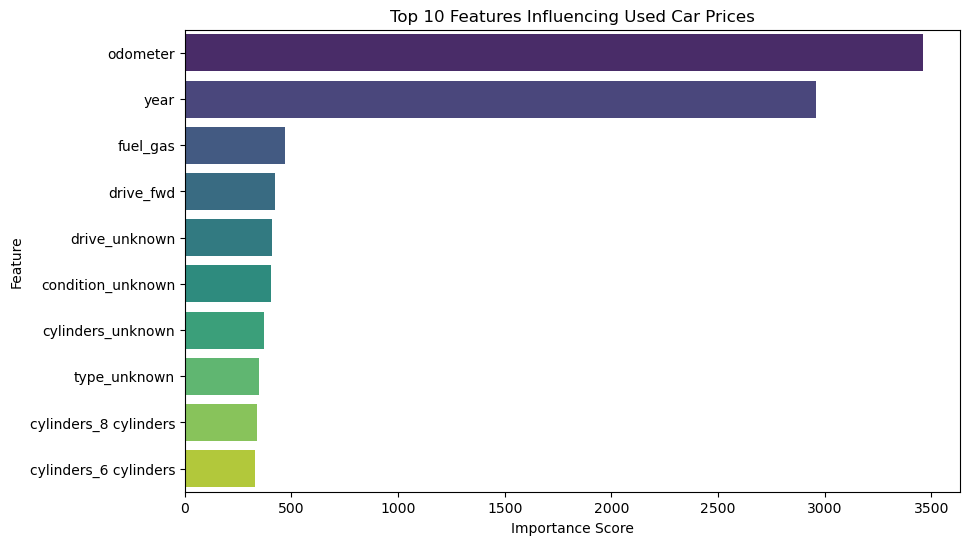

Key Takeaway: The chart above highlights the most critical factors for valuation (e.g., Age, Mileage).


In [9]:
# ---------------------------------------------------------
# CELL 9: Final Results & Interpretation
# ---------------------------------------------------------

# 9.1 Comparison Table
print("\n--- Model Performance Summary ---")
models_data = {
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'LightGBM'],
    'R2 Score': [r2_lr, r2_tree, r2_rf, r2_cb, r2_lgb]
}
df_results = pd.DataFrame(models_data).sort_values(by='R2 Score', ascending=False)
display(df_results)

print(f"-> Best Model: {df_results.iloc[0]['Model']} (R²={df_results.iloc[0]['R2 Score']:.3f})")

# 9.2 Feature Importance (Business Case)
print("\n--- Business Insight: What drives car prices? ---")

# Using LightGBM importances
importances = lgbm.feature_importances_
feature_names = X.columns
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(10)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
plt.title("Top 10 Features Influencing Used Car Prices")
plt.xlabel("Importance Score")
plt.show()

print("Key Takeaway: The chart above highlights the most critical factors for valuation (e.g., Age, Mileage).")